# Adversarial Search: Playing Connect 4

Student Name: Ryan Sweeney

I have used the following AI tools: Torch

I understand that my submission needs to be my own work: RS

## Instructions

Total Points: Undegraduates 100, graduate students 110

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

Note that [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [10 point]

Define the components of the search problem:

* Initial state
* Actions
* Transition model (result function)
* Goal state (terminal state and utility)

In [ ]:
# Your code/answer goes here.

How big is the state space? Give an estimate and explain it.

In [ ]:
# Your code/ answer goes here.

How big is the game tree that minimax search will go through? Give an estimate and explain it.

In [ ]:
# Your code/ answer goes here.

## Task 2: Game Environment and Random Agent [25 point]

Use a numpy character array as the board.

In [8]:
import numpy as np
import matplotlib.pyplot as plt

class ConnectFourBoard:
    def __init__(self, rows=6, columns=7):
        self.rows = rows
        self.columns = columns
        self.move_sequence = []  # List of moves using 1-based indexing

    def drop_piece(self, column):
        """ Record a move in the sequence for the given 1-based column number. """
        if column < 1 or column > self.columns:
            raise ValueError("Column out of bounds")
        if self.move_sequence.count(column) >= self.rows:
            raise ValueError("Column is full")
        self.move_sequence.append(column)  # Store as 1-based index

    def get_board_state(self):
        """ Reconstruct the board state from the move sequence. """
        board = np.zeros((self.rows, self.columns), dtype=int)
        player = 1  # Start with player 1
        for move in self.move_sequence:
            # Convert 1-based index to 0-based for processing
            move -= 1
            for r in range(self.rows-1, -1, -1):
                if board[r][move] == 0:
                    board[r][move] = player
                    break
            player *= -1  # Switch player
        return board

    def visualize(self):
        """ Visualize the board. """
        board = self.get_board_state()
        plt.axes()
        rectangle = plt.Rectangle((-0.5, self.rows * -1 + 0.5), self.columns, self.rows, fc='blue')
        plt.gca().add_patch(rectangle)

        for i in range(self.rows):
            for j in range(self.columns):
                val = board[i][j]
                color = 'white' if val == 0 else 'red' if val == 1 else 'yellow'
                circle = plt.Circle((j, i * -1), 0.4, fc=color)
                plt.gca().add_patch(circle)

        plt.axis('scaled')
        plt.show()


The standard board is $6 \times 7$ but you can use smaller boards to test your code. Instead of colors (red and yellow), I use 1 and -1 to represent the players. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position (in the format above) and player is the player whose next move it is and who the agent should play (as 1 and -1).

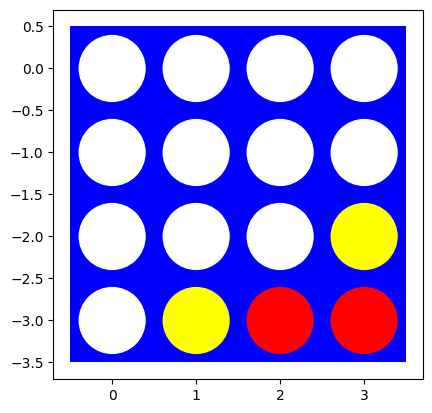

In [11]:
# Visualization code by Randolph Rankin

board = ConnectFourBoard()
board.drop_piece(4)  # Player 1 in column 3
board.drop_piece(4)  # Player 2 in column 3
board.drop_piece(3)  # Player 1 in column 4
board.drop_piece(2)  # Player 2 in column 3
board.visualize()

Implement helper functions for:

* A check for available actions in each state `actions(s)`.
* The transition model `result(s, a)`.
* Check for terminal states `terminal(s)`.
* The utility function `utility(s)`.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

In [21]:
# Your code/ answer goes here.
class ConnectFourBoard:
    def __init__(self, rows=6, columns=7):
        self.rows = rows
        self.columns = columns
        self.move_sequence = []  # List of moves using 1-based indexing

    def drop_piece(self, column):
        if column < 1 or column > self.columns:
            raise ValueError("Column out of bounds")
        if self.move_sequence.count(column) >= self.rows:
            raise ValueError("Column is full")
        self.move_sequence.append(column)

    def get_board_state(self):
        board = np.zeros((self.rows, self.columns), dtype=int)
        player = 1
        for move in self.move_sequence:
            move -= 1  # Convert to 0-based index
            for r in range(self.rows-1, -1, -1):
                if board[r][move] == 0:
                    board[r][move] = player
                    break
            player *= -1
        return board

    def actions(self):
        # Available actions: return columns that are not full
        return [c for c in range(1, self.columns + 1) if self.move_sequence.count(c) < self.rows]

    def result(self, action):
        # Result after action: returns a new board state after applying the action
        new_board = ConnectFourBoard(self.rows, self.columns)
        new_board.move_sequence = self.move_sequence[:]
        new_board.drop_piece(action)
        return new_board

    def terminal(self):
        if self.is_winner(1) or self.is_winner(-1):
            return True
        if all(self.move_sequence.count(c) == self.rows for c in range(1, self.columns + 1)):
            return True
        return False


    def utility(self):
        if self.is_winner(1):
            return 1  # Win for player 1
        elif self.is_winner(-1):
            return -1  # Win for player 2
        else:
            return 0  # Draw


    def is_winner(self, player):
        board = self.get_board_state()
        # Check horizontal, vertical, diagonal
        for r in range(self.rows):
            for c in range(self.columns):
                if (c <= self.columns - 4 and all(board[r][c + i] == player for i in range(4))) or \
                   (r <= self.rows - 4 and all(board[r + i][c] == player for i in range(4))) or \
                   (r <= self.rows - 4 and c <= self.columns - 4 and all(board[r + i][c + i] == player for i in range(4))) or \
                   (r <= self.rows - 4 and c >= 3 and all(board[r + i][c - i] == player for i in range(4))):
                    return True
        return False


    def visualize(self):
        board = self.get_board_state()
        plt.axes()
        rectangle = plt.Rectangle((-0.5, self.rows * -1 + 0.5), self.columns, self.rows, fc='blue')
        plt.gca().add_patch(rectangle)
        for i in range(self.rows):
            for j in range(self.columns):
                val = board[i][j]
                color = 'white' if val == 0 else 'red' if val == 1 else 'yellow'
                circle = plt.Circle((j, i * -1), 0.4, fc=color)
                plt.gca().add_patch(circle)
        plt.axis('scaled')
        plt.show()

Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = 1): ...`

The argument `player` is used for agents that do not store what color they are playing. The value passed on by the environment should be 1 ot -1 for player red and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [22]:
# Your code/ answer goes here.

def random_player(board, player = 1):
    return np.random.choice(board.actions())

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [28]:
# Your code/ answer goes here.

# Create a Connect Four board
board = ConnectFourBoard()

# Play 1000 games
results = []
for i in range(1000):
    # Reset the board
    board = ConnectFourBoard()
    # Play until the game is over
    while not board.terminal():
        # Player 1
        action = random_player(board, 1)
        board = board.result(action)
        if board.terminal():
            break
        # Player 2
        action = random_player(board, -1)
        board = board.result(action)
    results.append(board.utility())
    #visualize the board
    # board.visualize()
    
# Count the number of wins for each player
player1_wins = results.count(1)
player2_wins = results.count(-1)
draws = results.count(0)

print(f"Player 1 wins: {player1_wins}")
print(f"Player 2 wins: {player2_wins}")
print(f"Draws: {draws}")


Player 1 wins: 564
Player 2 wins: 435
Draws: 1


## Task 3: Minimax Search with Alpha-Beta Pruning

### Implement the Search [20 points]

Implement minimax search starting from a given board for specifying the player.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Important Notes:__
* Make sure that all your agent functions have a signature consistent with the random agent above and that it [uses a class to store state information.](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/HOWTOs/store_agent_state_information.ipynb)
This is essential to be able play against agents from other students later.
* The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [29]:
# Your code/ answer goes here.

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

In [45]:
import random 

class Position:
    WIDTH = 7
    HEIGHT = 6

    def __init__(self):
        self.board = [[0 for _ in range(self.HEIGHT)] for _ in range(self.WIDTH)]
        self.height = [0] * self.WIDTH
        self.moves = 0

    def can_play(self, col):
        return self.height[col] < self.HEIGHT

    def play(self, col):
        if not self.can_play(col):
            raise ValueError("Column is full or invalid move")
        self.board[col][self.height[col]] = 1 + self.moves % 2
        self.height[col] += 1
        self.moves += 1

    def is_winning_move(self, col):
        if not self.can_play(col):
            return False
        current_player = 1 + self.moves % 2

        # Check vertical alignment
        if (self.height[col] >= 3 and
            self.board[col][self.height[col] - 1] == current_player and
            self.board[col][self.height[col] - 2] == current_player and
            self.board[col][self.height[col] - 3] == current_player):
            return True

        # Check horizontal and diagonal alignments
        directions = [(-1, 0), (1, 0), (-1, -1), (1, 1), (-1, 1), (1, -1)]  # (dx, dy) pairs for directions
        for dx, dy in directions:
            count = 1  # Start with the current stone
            # Check in the positive direction
            x, y = col + dx, self.height[col] - 1 + dy
            while 0 <= x < self.WIDTH and 0 <= y < self.HEIGHT and self.board[x][y] == current_player:
                count += 1
                x += dx
                y += dy
            # Check in the negative direction
            x, y = col - dx, self.height[col] - 1 - dy
            while 0 <= x < self.WIDTH and 0 <= y < self.HEIGHT and self.board[x][y] == current_player:
                count += 1
                x -= dx
                y -= dy
            if count >= 4:
                return True

        return False

    def nb_moves(self):
        return self.moves
    
    def visualize_simple(self):
        for row in range(self.HEIGHT):
            print(" ".join(str(self.board[col][row]) for col in range(self.WIDTH)))
        print()

def negamax(position, alpha, beta):
    if position.nb_moves() == Position.WIDTH * Position.HEIGHT:
        return 0

    max_score = -float('inf')
    for col in range(Position.WIDTH):
        if position.can_play(col) and position.is_winning_move(col):
            return (Position.WIDTH * Position.HEIGHT + 1 - position.nb_moves()) // 2

    for col in range(Position.WIDTH):
        if position.can_play(col):
            new_position = Position()
            new_position.board = [row[:] for row in position.board]
            new_position.height = position.height[:]
            new_position.moves = position.moves
            new_position.play(col)
            score = -negamax(new_position, -beta, -alpha)
            if score >= beta:
                return score
            if score > max_score:
                max_score = score
            if score > alpha:
                alpha = score

    return alpha if max_score == -float('inf') else max_score

def create_random_position(position, move_count):
    for _ in range(move_count):
        possible_moves = [col for col in range(Position.WIDTH) if position.can_play(col)]
        if not possible_moves:
            break
        move = random.choice(possible_moves)
        position.play(move)
        if position.is_winning_move(move):  # End early if a win is detected
            break

In [51]:
import time

# Initialize the board and simulate some moves
move_count = random.randint(0, Position.WIDTH * Position.HEIGHT)  # Random depth
position = Position()
create_random_position(position, move_count)
#visualize the board
position.visualize_simple()

# Timing and evaluating the position
start_time = time.time()
score = negamax(position, -float('inf'), float('inf'))
elapsed_time = time.time() - start_time

print(f"Evaluated score: {score}")
print(f"Number of moves: {position.nb_moves()}")
print(f"Elapsed time: {elapsed_time:.6f} seconds")


0 1 0 0 0 0 2
0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 0 0 0 0 0


KeyboardInterrupt: 

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [ ]:
# Your code/ answer goes here.

#moves take varying times depending on how far into the game we are. A board with only 2 moves played takes a long time to evaluate, while a board with 20 moves played takes a very short time to evaluate.

### Move ordering [5 points]

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

In [ ]:
# Your code/ answer goes here.
class Position:
    WIDTH = 7
    HEIGHT = 6

    def __init__(self):
        self.board = [[0 for _ in range(self.HEIGHT)] for _ in range(self.WIDTH)]
        self.height = [0] * self.WIDTH
        self.moves = 0
        self.column_order = self.initialize_column_order()

    def initialize_column_order(self):
        # Generate column order prioritizing center columns
        order = list(range(self.WIDTH))
        order.sort(key=lambda x: abs(x - self.WIDTH // 2))
        return order

    def can_play(self, col):
        return self.height[col] < self.HEIGHT

    def play(self, col):
        if not self.can_play(col):
            raise ValueError("Column is full or invalid move")
        self.board[col][self.height[col]] = 1 + self.moves % 2
        self.height[col] += 1
        self.moves += 1

    def is_winning_move(self, col):
        if not self.can_play(col):
            return False
        current_player = 1 + self.moves % 2

        # Check vertical alignment
        if (self.height[col] >= 3 and
            self.board[col][self.height[col] - 1] == current_player and
            self.board[col][self.height[col] - 2] == current_player and
            self.board[col][self.height[col] - 3] == current_player):
            return True

        # Check horizontal and diagonal alignments
        directions = [(-1, 0), (1, 0), (-1, -1), (1, 1), (-1, 1), (1, -1)]  # (dx, dy) pairs for directions
        for dx, dy in directions:
            count = 1  # Start with the current stone
            # Check in the positive direction
            x, y = col + dx, self.height[col] - 1 + dy
            while 0 <= x < self.WIDTH and 0 <= y < self.HEIGHT and self.board[x][y] == current_player:
                count += 1
                x += dx
                y += dy
            # Check in the negative direction
            x, y = col - dx, self.height[col] - 1 - dy
            while 0 <= x < self.WIDTH and 0 <= y < self.HEIGHT and self.board[x][y] == current_player:
                count += 1
                x -= dx
                y -= dy
            if count >= 4:
                return True

        return False

    def nb_moves(self):
        return self.moves

def negamax(position, alpha, beta):
    if position.nb_moves() == Position.WIDTH * Position.HEIGHT:  # Check for draw
        return 0

    max_score = -float('inf')
    for col in position.column_order:
        if position.can_play(col) and position.is_winning_move(col):
            return (Position.WIDTH * Position.HEIGHT + 1 - position.nb_moves()) // 2

        if position.can_play(col):
            new_position = Position()
            new_position.board = [row[:] for row in position.board]
            new_position.height = position.height[:]
            new_position.moves = position.moves
            new_position.play(col)
            score = -negamax(new_position, -beta, -alpha)
            if score >= beta:
                return score
            if score > max_score:
                max_score = score
            if score > alpha:
                alpha = score

    return alpha if max_score == -float('inf') else max_score


### The first few moves [5 points]

Start with an empty board. This is the worst case scenario for minimax search since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do?

In [ ]:
# Your code/ answer goes here.

### Playtime [5 points]

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [ ]:
# Your code/ answer goes here.

## Task 4: Heuristic Alpha-Beta Tree Search

### Heuristic evaluation function [15 points]

Define and implement a heuristic evaluation function.

In [ ]:
# Your code/ answer goes here.

### Cutting Off Search [10 points]

Modify your minimax search with alpha-beta pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [ ]:
# Your code/ answer goes here.

Experiment with the same manually created boards as above to check if the agent spots wining opportunities.

In [ ]:
# Your code/ answer goes here.

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [ ]:
# Your code/ answer goes here.

### Playtime [5 points]

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [ ]:
# Your code/ answer goes here.

## Challenge task [up to +10 bonus point will be awarded separately]

Find another student and let your best agent play against the other student's best player. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [10 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+5 bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search and investigate how this search performs on the test boards that you have used above.

In [ ]:
# Your code/ answer goes here.

### Best First Move

Use Oure Monte Carlo Search to determine what the best first move is? Describe under what assumptions this is the "best" first move.  

In [ ]:
# Your code/ answer goes here.